In [3]:
import pandas as pd

# read the dataset
plain_dataset = pd.read_csv('C:/Users/jack/PycharmProjects/Spam-Classifier/datasets/Breast_cancer_data.csv')
# create a copy to not ruin the original data
work_dataset = plain_dataset

In [3]:
# a first look to the data
print(plain_dataset[:10])

   mean_radius  mean_texture  mean_perimeter  mean_area  mean_smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   
5        12.45         15.70           82.57      477.1          0.12780   
6        18.25         19.98          119.60     1040.0          0.09463   
7        13.71         20.83           90.20      577.9          0.11890   
8        13.00         21.82           87.50      519.8          0.12730   
9        12.46         24.04           83.97      475.9          0.11860   

   diagnosis  
0          0  
1          0  
2          0  
3          0  
4          0  
5          0  
6          0  
7          0  
8          0  
9          0 

In [9]:
# are there null values? how much rows do we have?
print(work_dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 6 columns):
mean_radius        569 non-null float64
mean_texture       569 non-null float64
mean_perimeter     569 non-null float64
mean_area          569 non-null float64
mean_smoothness    569 non-null float64
diagnosis          569 non-null int64
dtypes: float64(5), int64(1)
memory usage: 26.8 KB
None


In [10]:
# we are lucky, no null values! 
# let's see how values are disposed: the describe() method is very useful for this
print(work_dataset.describe())

       mean_radius  mean_texture  mean_perimeter    mean_area  \
count   569.000000    569.000000      569.000000   569.000000   
mean     14.127292     19.289649       91.969033   654.889104   
std       3.524049      4.301036       24.298981   351.914129   
min       6.981000      9.710000       43.790000   143.500000   
25%      11.700000     16.170000       75.170000   420.300000   
50%      13.370000     18.840000       86.240000   551.100000   
75%      15.780000     21.800000      104.100000   782.700000   
max      28.110000     39.280000      188.500000  2501.000000   

       mean_smoothness   diagnosis  
count       569.000000  569.000000  
mean          0.096360    0.627417  
std           0.014064    0.483918  
min           0.052630    0.000000  
25%           0.086370    0.000000  
50%           0.095870    1.000000  
75%           0.105300    1.000000  
max           0.163400    1.000000  


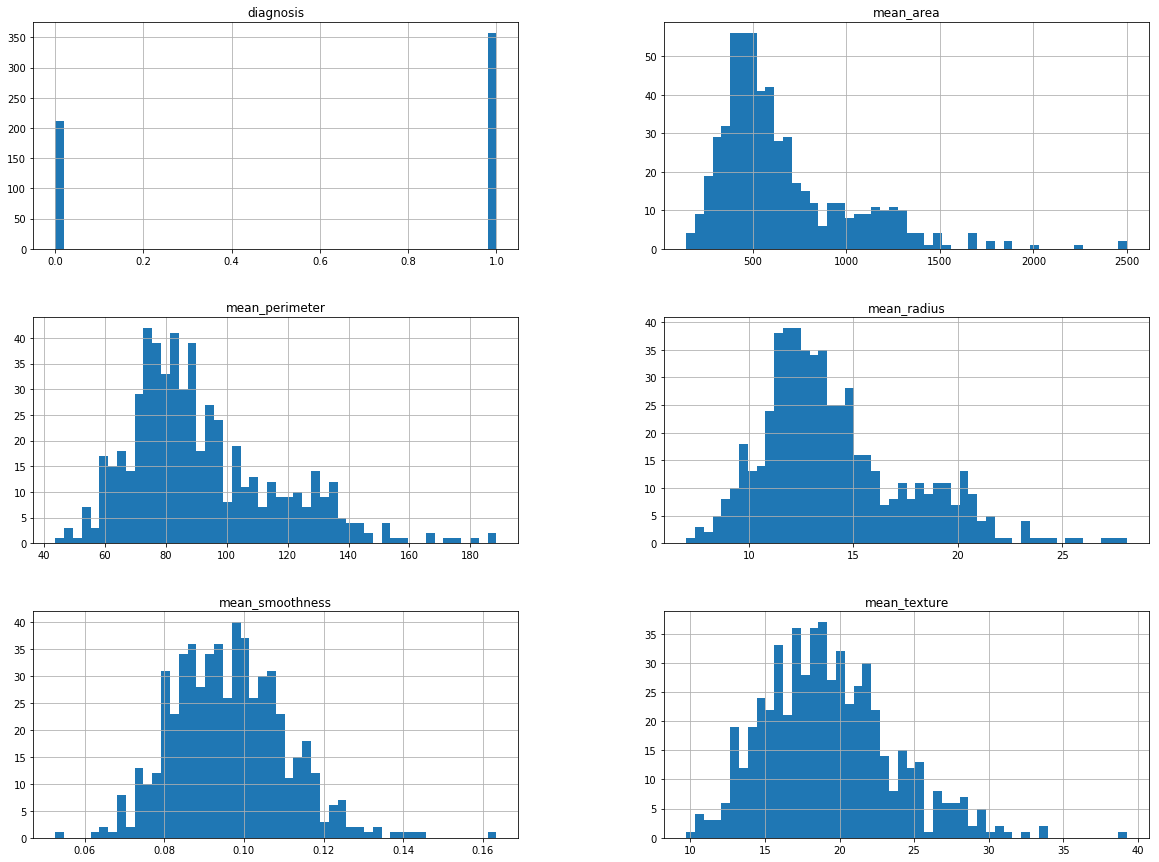

In [11]:
# Observations: we have a strong standard deviation in the mean_area attribute, implying 
# that values are well spread around the mean
# we can also notice how the mean of the diagnosis suggest that we have more 1 classes
# than the 0. So we have more benign cancers 

# let's plot the data
# thanks to histograms, we ca see *how* values are spread
# and rapidly see the outliers 
import matplotlib.pylab as plt
%matplotlib inline
work_dataset.hist(bins=50, figsize=(20, 15))
plt.show()

In [11]:
# before creating the validation and test set, i want to search for 
# some correlations between the class and the features, in order
# to make correctly stratified set: we want them representative of the entire dataset
corr_matrix = work_dataset.corr()
corr_matrix["diagnosis"].sort_values(ascending=True)


mean_perimeter    -0.742636
mean_radius       -0.730029
mean_area         -0.708984
mean_texture      -0.415185
mean_smoothness   -0.358560
diagnosis          1.000000
Name: diagnosis, dtype: float64

In [16]:
# we have a strong correlation (negative) between diagnosis and mean_perimeter, mean_radius
# and mean_area, but also others variable are not marginal
# we proceed creating the test and training set
# in general we don't have an attribute much more important than the others
# although I'm creating a pipeline with a transformer, to eliminate outlier values
# this operation can also has a negative impact on the performance of the models
# so i'll train models both on the with-outliers dataset and on the without-outliers one
# i'm also scaling the values thanks to the StandardScaler Transformer
# i'm building by my own the remove-Outlier Transformer
from sklearn.pipeline import Pipeline, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statistics as st


# outlier remove component
class Outlier(TransformerMixin):

    def __init__(self, **kwargs):
        try:
            self.threshold = kwargs.pop('neg_conf_val')
        except KeyError:
            self.threshold = -10.0
        pass
        self.kwargs = kwargs

    @staticmethod
    def transform(dataframe):
        attrib_list = []
        for attrib in dataframe:
            attrib_list.append(attrib)
            std = st.stdev(dataframe[attrib])
            mean = st.mean(dataframe[attrib])
            for id_value in range(0, len(dataframe[attrib])):
                if dataframe[attrib][id_value] > mean + 2 * std:
                    for col in dataframe.columns:
                        dataframe[col].values[id_value] = 0

        for val in range(0, len(dataframe[attrib_list[0]])):
            if dataframe[attrib_list[0]][val] == 0:
                dataframe = dataframe.drop(val)

        return dataframe

    def fit(self, *args, **kwargs):
        return self


pipe = Pipeline([
    ('outliers', Outlier()),
    ('scaler', StandardScaler())
])

# dataset without outliers
prepr = pipe.fit_transform(work_dataset)

train_set, test_set = train_test_split(work_dataset)
train_set_prep, test_set_prep = train_test_split(prepr)
print(prepr)


[[-0.64448709  0.48664334 -0.34312345 -0.77212351  3.36057199 -1.86685525]
 [-0.1391079  -0.73175521  0.01414225 -0.21479121  2.31464437 -1.86685525]
 [ 0.47912296  0.60379704  0.56042227  0.40256148  1.68139568 -1.86685525]
 ...
 [-0.75243216  2.82711405 -0.8378541  -0.77273596 -1.47844416  0.53566017]
 [ 1.89712865  2.49127343  1.85631588  2.11865499 -0.76265968 -1.86685525]
 [-2.44030053  1.56966427 -2.46667066 -2.02826476 -3.03381679  0.53566017]]


In [23]:
# let's now take a look at the scatter matrix, which can reveal some useful  
# details about the correlation among features
from pandas.plotting import scatter_matrix
%matplotlib inline


# take the names of the features
attributes = list(work_dataset)
scatter_matrix(work_dataset[attributes], figsize=(12, 8));



In [24]:
# good! let's divide now the train and test set, in features and targets. 
y_train = train_set["diagnosis"]
y_test = test_set["diagnosis"]
x_train = train_set.drop("diagnosis", axis=True)
x_test = test_set.drop("diagnosis", axis=True)



In [27]:

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# decision tree classifier
dct = DecisionTreeClassifier()
dct.fit(x_train, y_train)
dct_prediction = dct.predict(x_test)
dct_score = accuracy_score(dct_prediction, y_test)

print("decision tree classifier: ", dct_score)

decision tree classifier:  0.9230769230769231


In [1]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# SVM classifier
svm = SVC()
svm.fit(x_train, y_train)
svm_prediction = svm.predict(x_test)
svm_score = accuracy_score(svm_prediction, y_test)

print("SVM: ", svm_score)


NameError: name 'x_train' is not defined

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

#random forest classifier
rnd = RandomForestClassifier(n_estimators=100)
rnd.fit(x_train, y_train)
rnd_prediction = rnd.predict(x_test)
rnd_score = accuracy_score(rnd_prediction,y_test)

print("random forest classifier: ", rnd_score)

# we can see that the best accuracy is reached by the Decision Tree 
# classifier. The score is worse without outliers, so i don't apply
# the tranformation pipeline: in fact this can happen because 
# to remove outliers == to remove some kinf of information

random forest classifier:  0.958041958041958
